In [2]:
import os
import sys

import matplotlib.pyplot as plt
import pickle
import numpy as np 

In [3]:
def plot_psid_results(exp):
    with open('results/psid_' + exp + '_acc.pickle', 'rb') as handle:
        bscores, bscores_f = pickle.load(handle)

    #print(bscores_f[0])
    #fig, axs = plt.subplots(2)

    
    print("PSID - mean accuracy :  ",np.mean(bscores[0]))

    #print("PSID - mean accuracy (filtered data) : ", np.mean(bscores_f[0]))
    plt.boxplot(bscores[0])
    plt.show()
    print("PSID - XGB FEATURE IMPORTANCE")
    
    for i in range(len(bscores[1])):
        plt.imshow(bscores[1][i].reshape((7,20)))
        plt.show()

In [20]:
search_range = range(5, 35, 2)
def plot_csp_results(exp):
    with open('results/csp_' + exp + '_acc.pickle', 'rb') as handle:
        bscores = pickle.load(handle)
    max_idx = np.argmax([np.mean(b) for b in bscores])
    print("CSP - maximal accuracy over 2hz frequency bands : ", np.mean(bscores[max_idx]))
    plt.boxplot(bscores)
    plt.xticks(range(len(search_range)),search_range)
    plt.suptitle("CSP accuracy for 2hz frequency bands")
    plt.show()
    return bscores[max_idx]

    

In [21]:
#CLASSIFIERS
import xgboost as xgb
xgb_model = xgb.XGBClassifier(max_depth=5,
                          n_estimators=10,
                          n_jobs=3,
                          eval_metric="logloss",
                          use_label_encoder=False)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis("eigen",shrinkage="auto")

from sklearn.linear_model import RidgeClassifier
ridge_model = RidgeClassifier()

from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()

In [2]:
import numpy as np
freq_ranges = [(5, 8), (8, 13), (13, 30)]#, (128, 132)]
freq_nbs = [1, 3, 3]#, 1]

fb = []
for i_, f in enumerate(freq_ranges):
    points = np.linspace(f[0], f[1], num=freq_nbs[i_] + 1)
    fb += [(points[i], points[i + 1]) for i in range(len(points) - 1)]


In [3]:
fb

[(5.0, 8.0),
 (8.0, 9.666666666666666),
 (9.666666666666666, 11.333333333333334),
 (11.333333333333334, 13.0),
 (13.0, 18.666666666666668),
 (18.666666666666668, 24.333333333333336),
 (24.333333333333336, 30.0)]

In [22]:
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score
def auc_scoring(y, y_pred):
    auc_threshold = np.median(y)
    print(auc_threshold)
    ix_true = np.where(y > auc_threshold)[0]
    y_binary = np.zeros(y.shape)
    y_binary[ix_true] = 1
    score = roc_auc_score(y_binary, y_pred - auc_threshold)
    print()
    return score
sys.path.append("..")
from utils.features_utils import block_crossval

In [23]:
def psid_classification(exp,
                       metric = roc_auc_score,
                       model_class = xgb_model,
                       freq_buckets = [0,1,2,3,4,5,6],
                       psid_dims = list(range(20)),
                       ):
    metric = roc_auc_score #accuracy_score #auc_scoring

    with open('results/psid_' + exp + '.pickle', 'rb') as handle:
        X, y, blocks_idx = pickle.load(handle)
    nb_obs = X.shape[0]
    X = X.reshape((nb_obs,7,20))
    X = X[:, freq_buckets , :] 
    X = X[:,:,psid_dims]
    X = X.reshape((nb_obs,-1))

    crossval_res = block_crossval(X, y, model_class, blocks_idx, 
                                  metric = metric,
                                  do_plot=False, 
                                  do_feature_imp=False)

    return crossval_res

Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.9861111111111112, 0.8888888888888888, 0.9166666666666667, 0.9166666666666667, 0.9583333333333333] - 93.33%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.9583333333333333, 0.9027777777777778, 0.9305555555555555, 0.9166666666666667, 1.0] - 94.17%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.9166666666666667, 0.8472222222222222, 0.7916666666666667, 0.7916666666666665, 0.8472222222222222] - 83.89%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.7777777777777777, 0.75, 0.7083333333333334, 0.6388888888888888, 0.6805555555555555] - 71.11%
CSP - maximal accuracy over 2hz frequency bands :  0.65


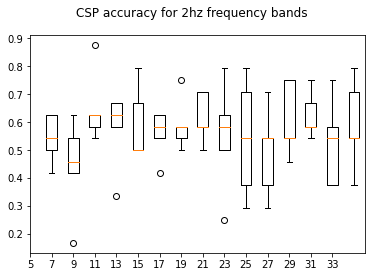

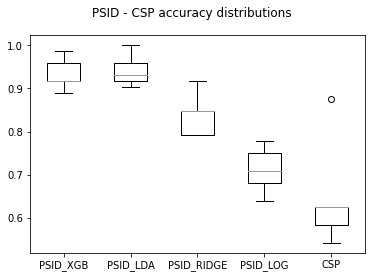

In [25]:
exp = "1"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.8472222222222222, 0.7777777777777777, 0.8055555555555556, 0.8611111111111112, 0.8611111111111112] - 83.06%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.9027777777777777, 0.8472222222222222, 0.8055555555555555, 0.861111111111111, 0.6805555555555557] - 81.94%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.5833333333333334, 0.6527777777777779, 0.5694444444444444, 0.6944444444444444, 0.5416666666666667] - 60.83%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.5555555555555556, 0.5833333333333333, 0.5555555555555556, 0.625, 0.48611111111111116] - 56.11%
CSP - maximal accuracy over 2hz frequency bands :  0.5797619047619048


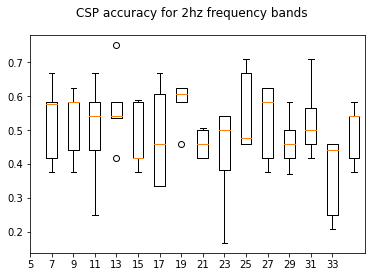

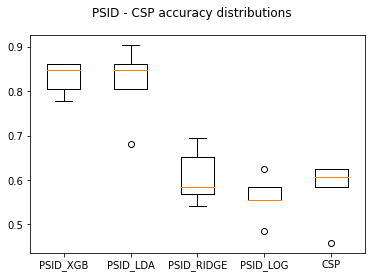

In [26]:
exp = "2"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Scores: [0.75, 0.888888888888889, 0.6805555555555554] - 77.31%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Scores: [0.7083333333333334, 0.8749999999999999, 0.7222222222222222] - 76.85%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Scores: [0.5833333333333333, 0.6666666666666666, 0.5972222222222222] - 61.57%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Scores: [0.5694444444444444, 0.5555555555555556, 0.6111111111111112] - 57.87%
CSP - maximal accuracy over 2hz frequency bands :  0.6388888888888888


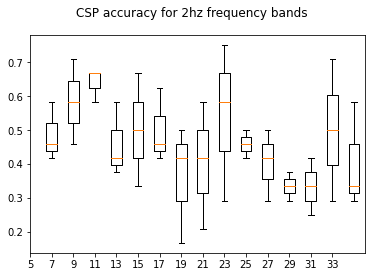

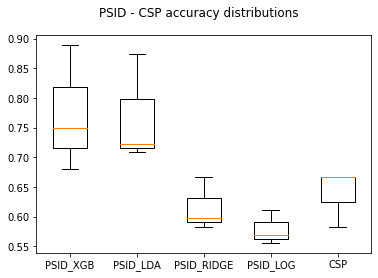

In [27]:
exp = "3"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Scores: [0.9305555555555556, 1.0, 0.9166666666666667, 0.9166666666666666] - 94.10%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Scores: [0.9722222222222222, 1.0, 0.9722222222222222, 0.9444444444444444] - 97.22%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Scores: [0.7638888888888888, 0.7222222222222222, 0.8472222222222222, 0.8333333333333334] - 79.17%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Scores: [0.736111111111111, 0.69

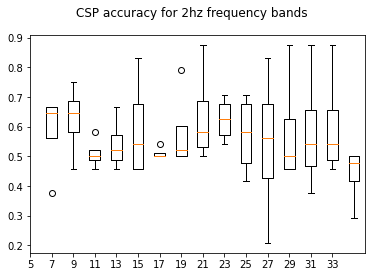

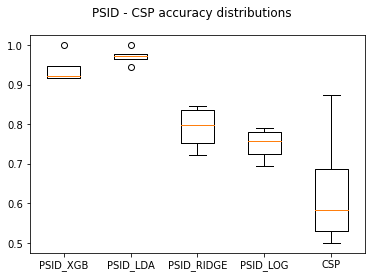

In [28]:
exp = "4"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.5972222222222222, 0.9027777777777778, 0.8333333333333333, 0.8055555555555555, 0.8472222222222222] - 79.72%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.513888888888889, 0.9722222222222222, 0.861111111111111, 0.875, 0.9305555555555556] - 83.06%
Not all the same number of groups per label - will zip and thus drop all groups longer than the min
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Scores: [0.055555555555555566, 0.7222222222222223, 0.8472222222222222, 0.7916666666666667, 0.7222222222222222] - 62.78%
Not all the same number of groups per label - will zip and thus drop all g

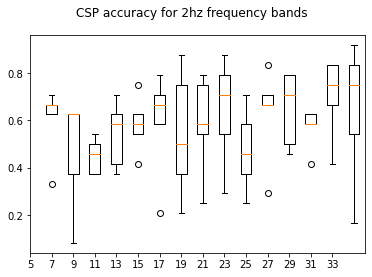

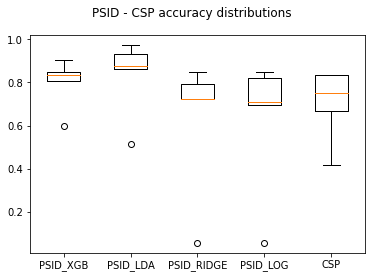

In [29]:
exp = "5"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Scores: [0.9583333333333333, 0.9583333333333333, 1.0, 0.9722222222222222, 1.0, 0.9722222222222222, 1.0, 1.0, 0.986111111111111] - 98.30%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Scores: [0.9722222222222222, 0.9583333333333333, 0.9722222222222222, 0.9583333333333333, 1.0, 0.9583333333333333, 1.0, 0.9722222222222222, 1.0] - 97.69%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Scores: [0.9027777777777778, 0.7361111111111112, 0.9305555555555556, 0.888888888888889, 0.9444444444444444, 0.9722222222222222, 0.9305555555555556, 0.8611111111111112, 0.9305555555555555] - 89.97%


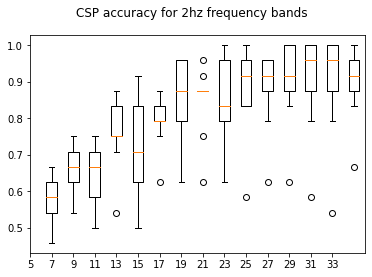

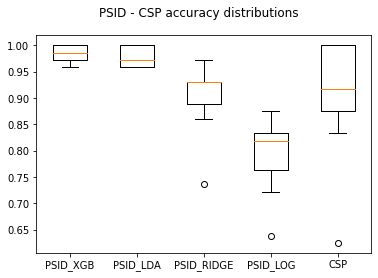

In [30]:
exp = "6"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Scores: [0.8194444444444444, 0.9583333333333333, 0.875, 0.9305555555555554, 0.8611111111111112, 0.9444444444444444, 0.8611111111111112] - 89.29%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Scores: [0.9583333333333333, 0.8472222222222223, 0.875, 0.8472222222222222, 0.9305555555555556, 0.9583333333333333, 0.9166666666666665] - 90.48%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Scores: [0.8611111111111112, 0.7222222222222223, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8472222222222222, 0.8472222222222222] - 82.54%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Scores: [0.805555555

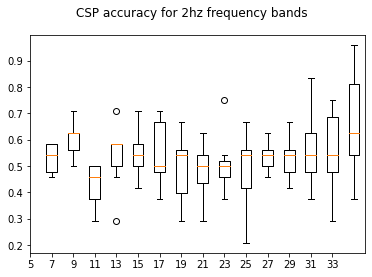

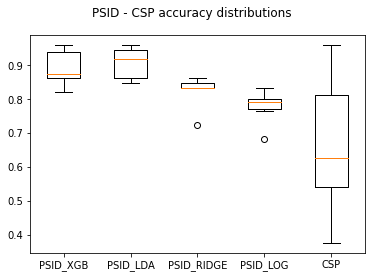

In [31]:
exp = "7"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Scores: [0.726010101010101, 0.8333333333333333, 0.8333333333333333, 0.9305555555555556, 0.7916666666666665, 0.8194444444444444, 0.9166666666666666, 0.9027777777777778, 0.9166666666666667] - 85.23%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Scores: [0.7891414141414141, 0.6944444444444444, 0.6944444444444444, 0.8194444444444446, 0.888888888888889, 0.8055555555555556, 0.8472222222222222, 0.888888888888889, 0.8009259259259259] - 80.32%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Processing split 9
Scores: [0.6313131313131313, 0.6666666666666666, 0.6527777777777778, 0.8194444444444444, 0.847

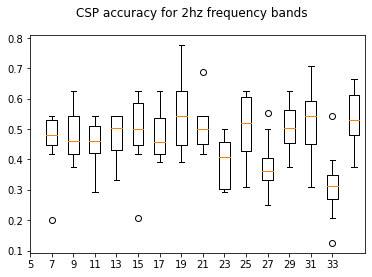

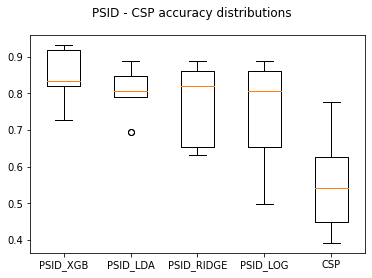

In [32]:
exp = "8"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Author's results with CSP (purple) :
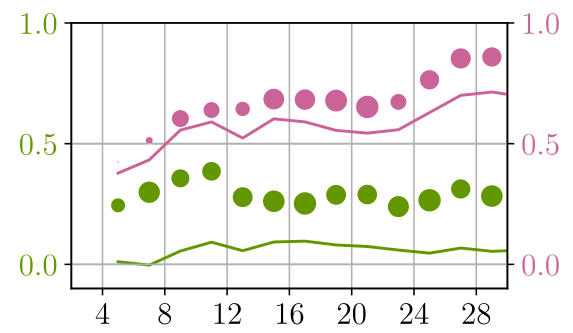


Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Scores: [0.9027777777777778, 0.875, 0.9305555555555556, 0.9027777777777778, 0.9027777777777778, 0.8194444444444444, 0.861111111111111, 0.9444444444444444] - 89.24%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Scores: [0.9166666666666667, 0.9861111111111112, 0.9166666666666665, 0.9583333333333333, 0.9305555555555556, 0.8194444444444443, 0.9444444444444445, 0.9722222222222222] - 93.06%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Scores: [0.7499999999999999, 0.8472222222222222, 0.7916666666666667, 0.7777777777777778, 0.8333333333333334, 0.6944444444444444, 0.8611111111111112, 0.875] - 80.38%
Processing split 1
Processing split 2

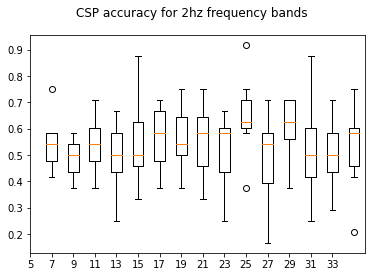

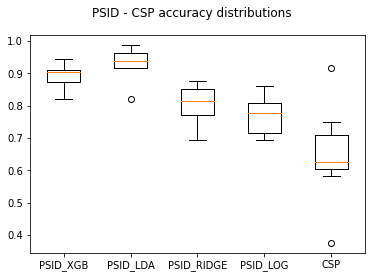

In [33]:
exp = "9"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Author's results with CSP (purple) :
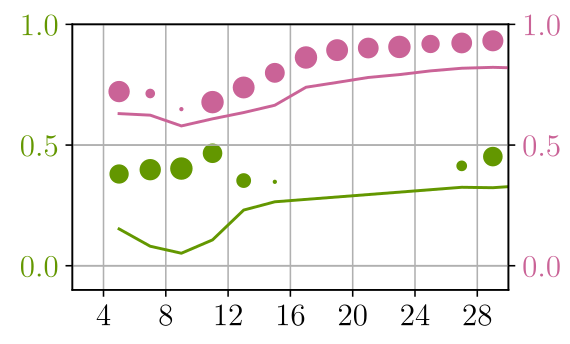


Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Scores: [0.9305555555555556, 0.9444444444444444, 0.986111111111111, 0.9583333333333333, 0.9444444444444444, 0.9027777777777777, 0.8472222222222222, 0.9444444444444444] - 93.23%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Scores: [0.9583333333333333, 0.9305555555555556, 0.9305555555555555, 0.9583333333333333, 0.9583333333333333, 0.9027777777777777, 0.8472222222222222, 0.9166666666666667] - 92.53%
Processing split 1
Processing split 2
Processing split 3
Processing split 4
Processing split 5
Processing split 6
Processing split 7
Processing split 8
Scores: [0.8055555555555556, 0.875, 0.8194444444444443, 0.8472222222222222, 0.8750000000000001, 0.7361111111111112, 0.75, 0.8611111111111112] - 82.12%
Processing split 1
Processing split 2


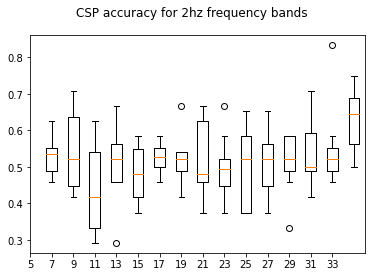

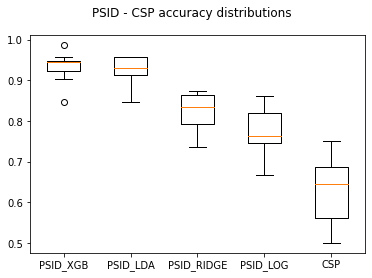

In [34]:
exp = "10"
res_xgb = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = xgb_model,)
res_lda = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = lda_model,)
res_ridge = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = ridge_model,)
res_log = psid_classification(exp,
                         metric=accuracy_score,
                         model_class = logreg_model,)
res_csp = plot_csp_results(exp)

plt.boxplot([res_xgb,res_lda,res_ridge,res_log, res_csp])
plt.xticks([1,2,3,4,5],["PSID_XGB","PSID_LDA","PSID_RIDGE","PSID_LOG","CSP"])
plt.suptitle("PSID - CSP accuracy distributions")
plt.show()


Author's results with CSP (purple) :
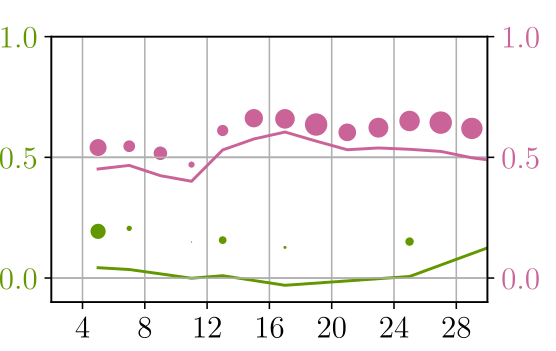